# Knowledge Graph of Integrated Frame

## Imports and Load Data

In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

spacy.prefer_gpu()
nlp = spacy.load('en_core_web_trf')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# import wikipedia sentences
all_sentences = pd.read_csv("D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\labeled_clusters99.csv")
all_sentences.shape

(8376, 4)

In [3]:
type(all_sentences)

pandas.core.frame.DataFrame

In [4]:
all_sentences['Processed_Title'].sample(5)

2319    Nigerian photographer confirms that he tested positive for Coronavirus after attending AMVCA
661                                     Coronavirus: Three from China admitted to Hyderabad hospital
5385                             Surge In Confirmed Coronavirus Cases Due To Better Testing: Experts
4704                                                 Coronavirus: No. of infected down again English
1752                         FEMA Says at Least 7 People at the Disaster Agency Have the Coronavirus
Name: Processed_Title, dtype: object

In [9]:
# Corpus with example sentences
category_sentences = all_sentences[all_sentences['category']=='passes_bill_coronavirus_relief']
category_sentences.head()

,Processed_Title,label_st1,label,category
11,House passes bill to help prop up economy from coronavirus,-1,coronavirus_coronavirus_pandemic,passes_bill_coronavirus_relief
311,NYC lawmaker unveils coronavirus rent relief bill,-1,coronavirus_coronavirus_pandemic,passes_bill_coronavirus_relief
317,House Passes Coronavirus Relief Package,-1,coronavirus_coronavirus_pandemic,passes_bill_coronavirus_relief
578,House to Vote After Trump Signals Support for Coronavirus Bill,-1,coronavirus_coronavirus_pandemic,passes_bill_coronavirus_relief
1382,House passes sweeping coronavirus relief bill,-1,coronavirus_coronavirus_pandemic,passes_bill_coronavirus_relief


In [10]:
candidate_sentences = pd.DataFrame(category_sentences['Processed_Title'])
candidate_sentences.head()

,Processed_Title
11,House passes bill to help prop up economy from coronavirus
311,NYC lawmaker unveils coronavirus rent relief bill
317,House Passes Coronavirus Relief Package
578,House to Vote After Trump Signals Support for Coronavirus Bill
1382,House passes sweeping coronavirus relief bill


In [11]:
type(candidate_sentences)

pandas.core.frame.DataFrame

In [12]:
doc = nlp(candidate_sentences.iloc[0,0])
for tok in doc:
  print(tok.text, "...", tok.dep_)

House ... nsubj
passes ... ROOT
bill ... dobj
to ... aux
help ... relcl
prop ... xcomp
up ... prt
economy ... dobj
from ... prep
coronavirus ... pobj


## Entity Extractor

In [13]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [14]:
get_entities(candidate_sentences.iloc[0,0])

['House', 'coronavirus']

In [15]:
entity_pairs = []

for i in tqdm(candidate_sentences['Processed_Title']):
  entity_pairs.append(get_entities(i))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.95it/s]


In [16]:
entity_pairs[0:20]

[['House', 'coronavirus'],
 ['NYC lawmaker', 'rent relief bill'],
 ['House', 'Coronavirus Relief Package'],
 ['Trump', 'Coronavirus Bill'],
 ['House', 'sweeping coronavirus relief bill'],
 ['Sen. Chuck Schumer', 'coronavirus relief bill'],
 ['upper  house', 'coronavirus bills'],
 ['House', 'sweeping coronavirus aid package'],
 ['Coronavirus Relief Trump', 'Support'],
 ['US House', 'Coronavirus Relief Package'],
 ['Coronavirus Trump', 'Support'],
 ['House', 'coronavirus aid Senate'],
 ['U.S. House', 'sweeping coronavirus package bill'],
 ['House', 'Bipartisan Coronavirus Relief Bill'],
 ['House', 'Coronavirus Relief Bill']]

## Relation Extractor

In [17]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [18]:
type(candidate_sentences)

pandas.core.frame.DataFrame

In [19]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Processed_Title'])]

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 37.41it/s]


In [20]:
pd.Series(relations).value_counts()[:50]

Passes               5
passes sweeping      3
passes               2
unveils              1
Vote                 1
pushes               1
tweaks               1
Passes Bipartisan    1
dtype: int64

## Build Connections

In [21]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [22]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

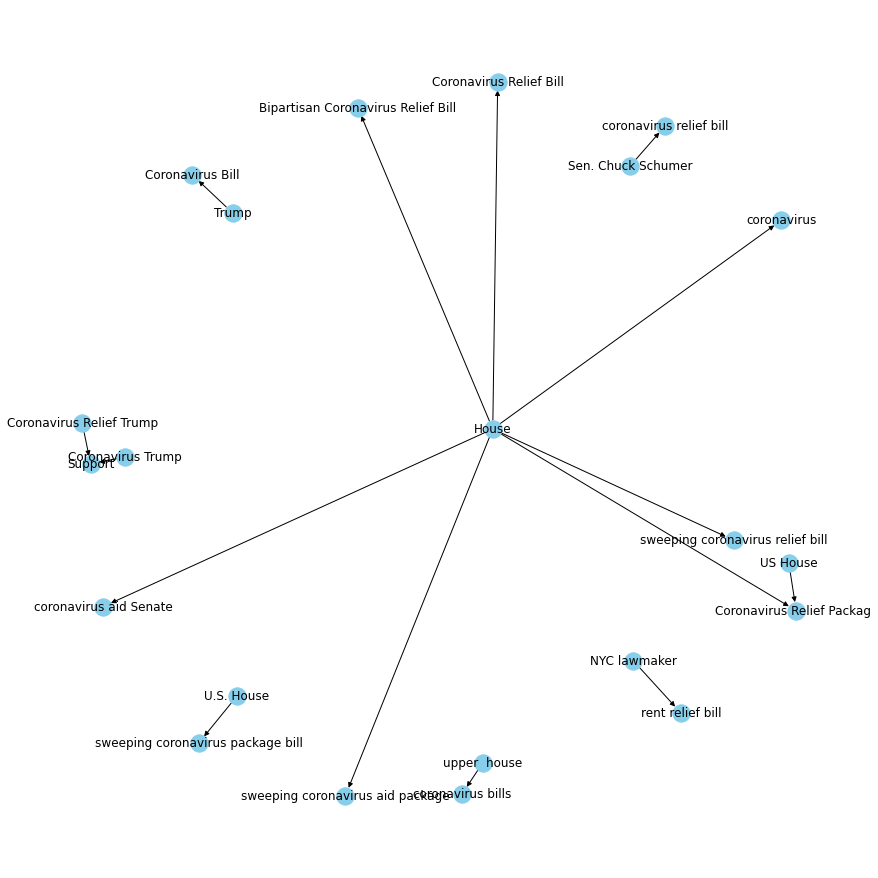

In [23]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

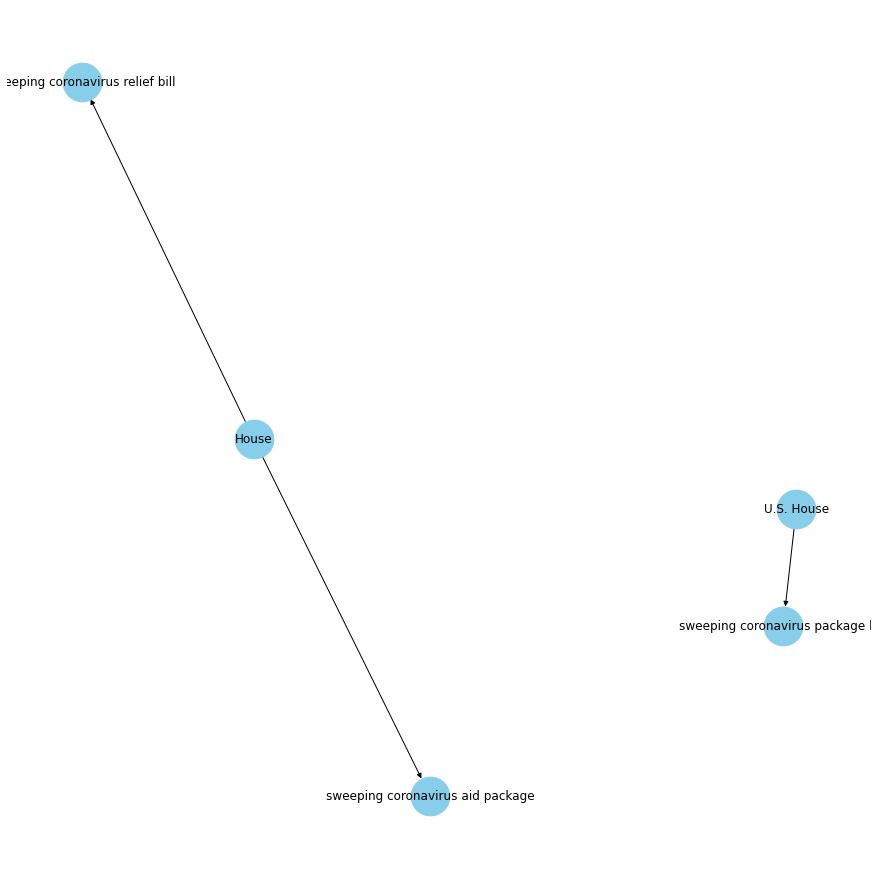

In [27]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="passes sweeping"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

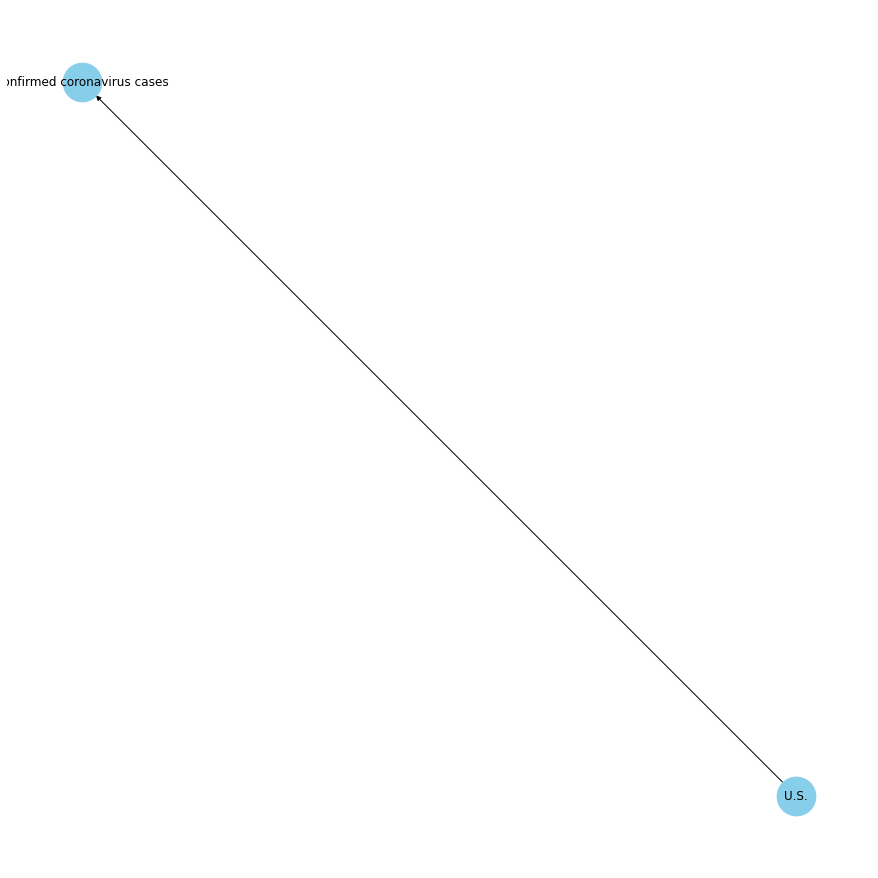

In [95]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="surpasses"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

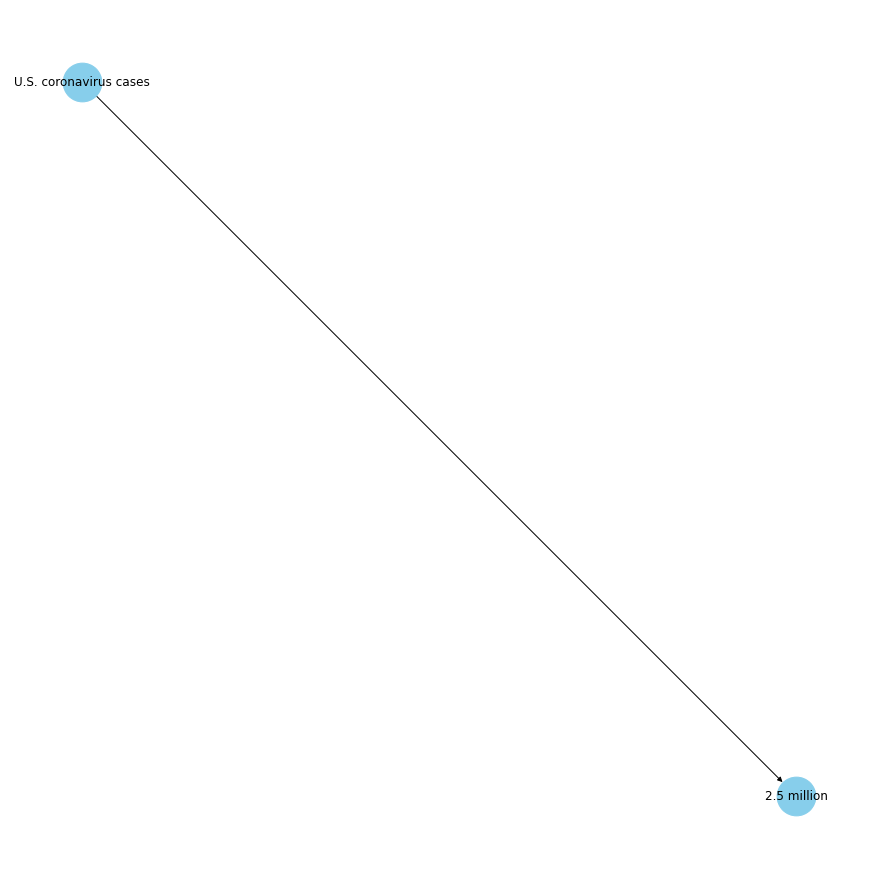

In [94]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="tally"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [96]:
# Corpus with example sentences
category_sentences = all_sentences[all_sentences['label']=='reports_case_coronavirus_death']
category_sentences.head()

,Processed_Title,label_st1,label,category
0,"US coronavirus death toll rises to 14, most cases in Washington",85,reports_case_coronavirus_death,rises_37_coronavirus_death
36,27 coronavirus patients recover in Landikotal,85,reports_case_coronavirus_death,records_death_coronavirus_patient
61,Coronavirus toll reaches 37 in Washington,85,reports_case_coronavirus_death,rises_37_coronavirus_death
63,"Indiana Announces 2 More Coronavirus Deaths, Bringing Total To 6",85,reports_case_coronavirus_death,announces_death_coronavirus_total
107,"Coronavirus live updates: US surpasses 65,000 COVID 19 deaths",85,reports_case_coronavirus_death,coronavirus_coronavirus_case


In [97]:
category_sentences.shape

(336, 4)

In [98]:
candidate_sentences = pd.DataFrame(category_sentences['Processed_Title'])
candidate_sentences.head()

,Processed_Title
0,"US coronavirus death toll rises to 14, most cases in Washington"
36,27 coronavirus patients recover in Landikotal
61,Coronavirus toll reaches 37 in Washington
63,"Indiana Announces 2 More Coronavirus Deaths, Bringing Total To 6"
107,"Coronavirus live updates: US surpasses 65,000 COVID 19 deaths"


In [99]:
entity_pairs = []

for i in tqdm(candidate_sentences['Processed_Title']):
  entity_pairs.append(get_entities(i))

100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [00:04<00:00, 78.61it/s]


In [100]:
entity_pairs[0:20]

[['coronavirus death toll', 'most  Washington'],
 ['27 coronavirus patients', 'Landikotal'],
 ['Coronavirus toll', 'Washington'],
 ['Indiana', 'More Coronavirus 6'],
 ['live  US', '65,000  COVID'],
 ['CDC', '3,416,428 coronavirus cases'],
 ['leading  doctor', 'leading  America'],
 ['20 Million 20 Americans', 'New  Coronavirus'],
 ['coronavirus cases', 'schools'],
 ['Coronavirus cases', 'Washington'],
 ['City', 'Down Coronavirus Battle'],
 ['Coronavirus death toll', '106'],
 ['Coronavirus infections', '500'],
 ['Reese Witherspoon', 'Nashville tornado'],
 ['Coronavirus cases', '100,000'],
 ['national coronavirus total', '37'],
 ['coronavirus death toll', '2  days'],
 ['Arteta', 'completely  coronavirus'],
 ['Rich Rushing', 'coronavirus'],
 ['Coronavirus deaths', 'October']]

In [101]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['Processed_Title'])]

100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [00:04<00:00, 79.04it/s]


In [102]:
pd.Series(relations).value_counts()[:50]

reports               19
top                   12
rises to               6
confirms               6
Coronavirus            6
rise to                5
says                   5
reach                  5
surpasses              4
closes                 4
reaches                3
Tops                   3
has                    3
tally                  3
is                     3
updates                3
's                     3
exceed                 2
passes                 2
hits                   2
Dying From             2
Says                   2
deaths on              2
pass                   2
increases to           2
are on                 2
Coronavirus latest     2
reports biggest        2
Pass                   2
cases                  2
projected              2
estimates              2
records                2
crosses                2
Toll At                2
cases in               2
surge past             2
recovered              2
surpass                2
Exceeds                2


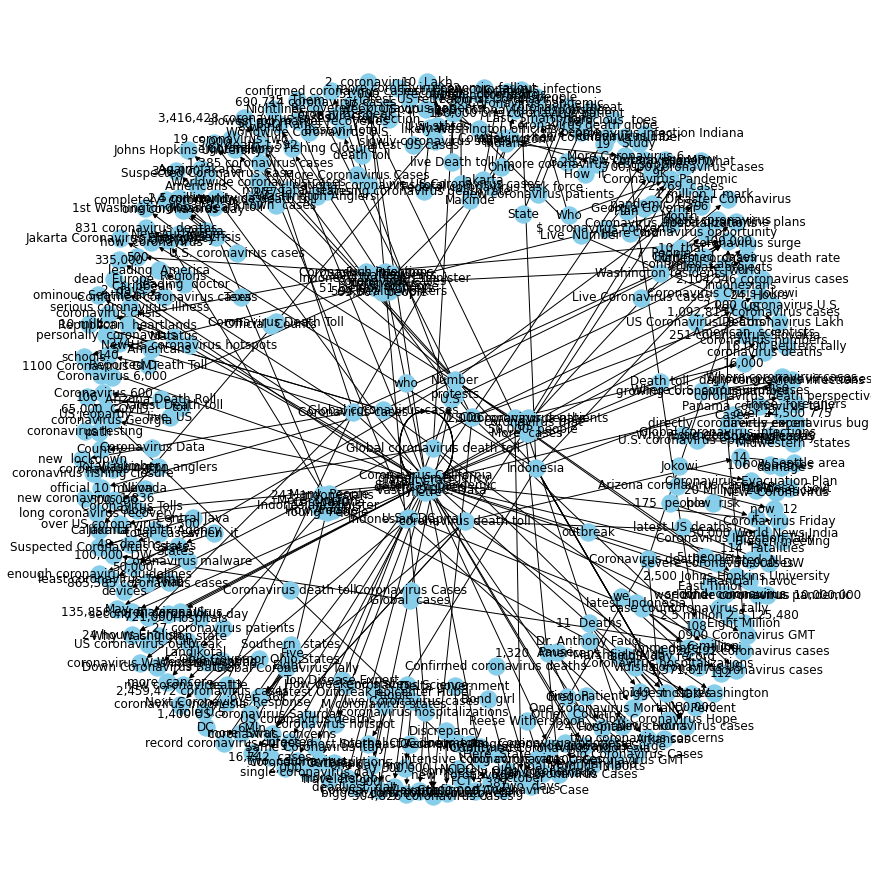

In [103]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

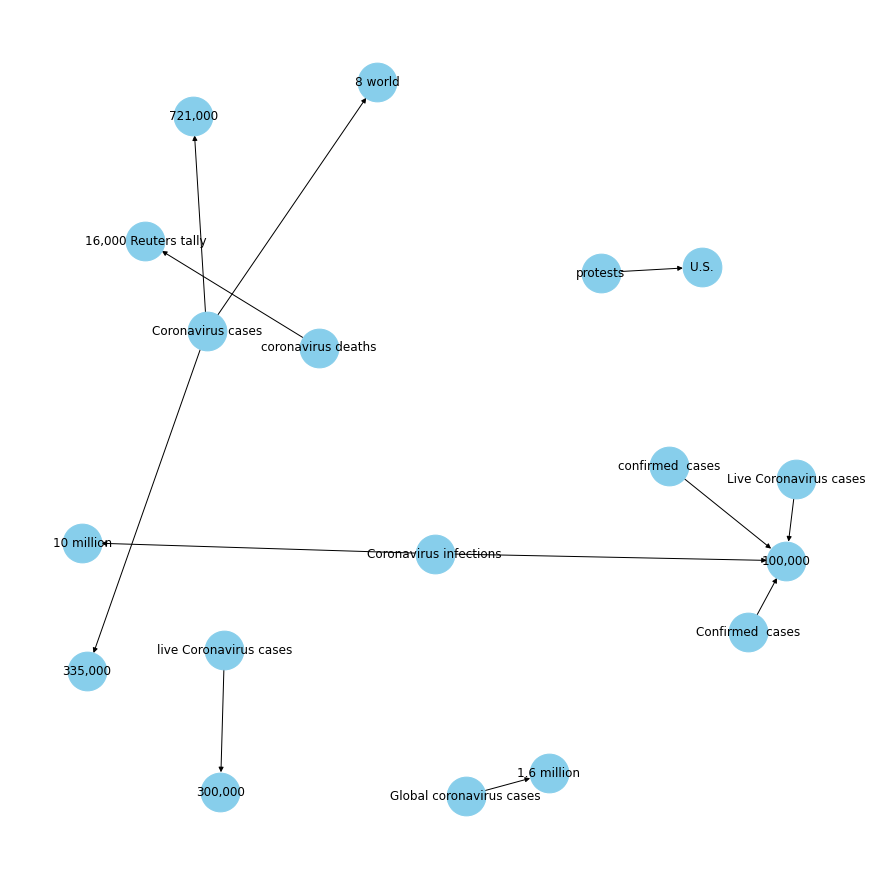

In [105]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="top"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()